In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path

['/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning',
 '/opt/conda/lib/python38.zip',
 '/opt/conda/lib/python3.8',
 '/opt/conda/lib/python3.8/lib-dynload',
 '',
 '/home/blessyantony/.local/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages/IPython/extensions',
 '/home/blessyantony/.ipython',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning/../../../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning/../../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning/../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning/../..']

In [2]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.metrics import roc_curve, accuracy_score, f1_score, auc, precision_recall_curve
from statistics import mean

from src.utils import utils, evaluation_utils, visualization_utils

In [5]:
output_file_path = os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_idv/20240611/host_multi/few_shot_learning/fsl_idv_uniref90viridae_msl2048_transformer-l_6-h_8-d_1024-lr1e-4_classwise_auprc.csv")

In [8]:
df = pd.read_csv(output_file_path, index_col=0)

In [9]:
df

,class,auprc,itr
0,Cercocebus torquatus,0.560947,0
1,Homo sapiens,0.668640,0
2,Puma concolor,0.495465,0
3,Cercopithecus solatus,0.656869,0
4,Macaca mulatta,0.816001,0
...,...,...,...
295,Macaca mulatta,0.848942,4
296,Macaca nemestrina,0.935176,4
297,Cercocebus torquatus,0.775173,4
298,Cercopithecus nictitans,0.662214,4


In [10]:
df["class"].unique()

array(['Cercocebus torquatus', 'Homo sapiens', 'Puma concolor',
       'Cercopithecus solatus', 'Macaca mulatta', 'Mandrillus sphinx',
       'Cercopithecus nictitans', 'Cercocebus atys', 'Macaca nemestrina',
       'Felis catus', 'Mandrillus leucophaeus'], dtype=object)

<Figure size 432x288 with 0 Axes>

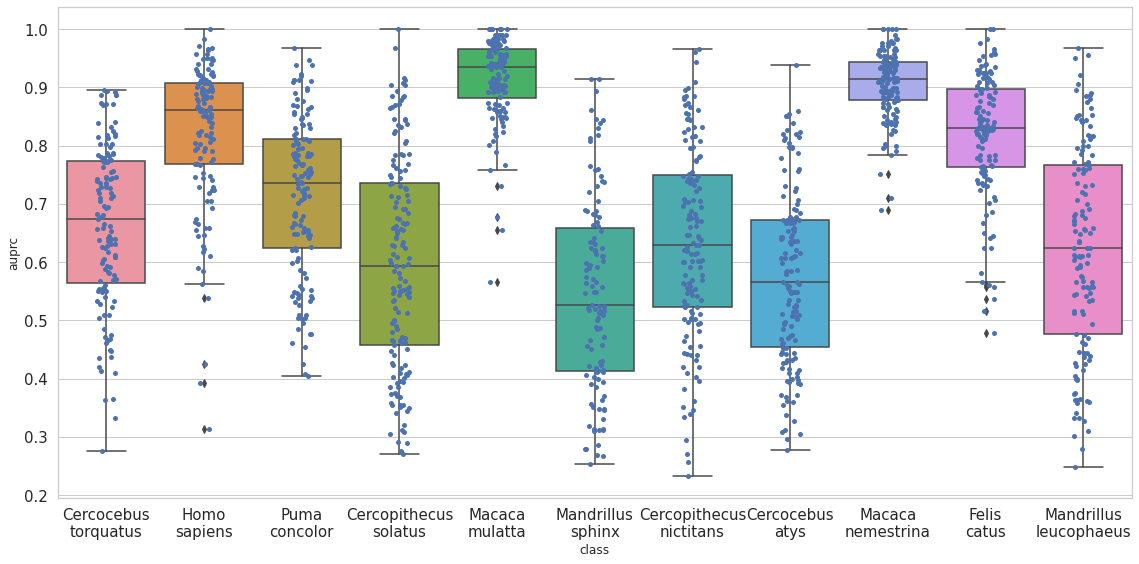

In [19]:
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['figure.autolayout'] = True

DEFAULT_FIGURE_CONFIG = {
    "figsize": (16, 8),
    "xtick.labelsize": 15,
    "ytick.labelsize": 15    
}

visualization_utils.pre_plot_config(DEFAULT_FIGURE_CONFIG)
ax = sns.boxplot(data=df, x="class", y="auprc")
sns.stripplot(data=df, x="class", y="auprc", ax=ax)
plt.draw()
visualization_utils.wrap_ticklabels(ax, axis="x")

In [20]:
output_file_path = os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_idv/20240611/host_multi/few_shot_learning/fsl_idv_uniref90viridae_msl2048_transformer-l_6-h_8-d_1024-lr1e-4_output.csv")

In [21]:
df = pd.read_csv(output_file_path, index_col=0)

In [22]:
df

,Cercocebus torquatus,Homo sapiens,Puma concolor,y_true,Cercopithecus solatus,Macaca mulatta,Mandrillus sphinx,Cercopithecus nictitans,Cercocebus atys,Macaca nemestrina,Felis catus,Mandrillus leucophaeus,itr
0,0.885559,0.110253,0.004188,Cercocebus torquatus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,0.374630,0.092263,0.533107,Cercocebus torquatus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,0.056965,0.208990,0.734045,Cercocebus torquatus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,0.736625,0.202603,0.060772,Cercocebus torquatus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,0.990599,0.007073,0.002327,Cercocebus torquatus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0.012537,NaN,NaN,Mandrillus leucophaeus,NaN,NaN,NaN,0.096752,NaN,NaN,NaN,0.890712,4
2996,0.028757,NaN,NaN,Mandrillus leucophaeus,NaN,NaN,NaN,0.776685,NaN,NaN,NaN,0.194557,4
2997,0.290067,NaN,NaN,Mandrillus leucophaeus,NaN,NaN,NaN,0.133301,NaN,NaN,NaN,0.576631,4
2998,0.021119,NaN,NaN,Mandrillus leucophaeus,NaN,NaN,NaN,0.040057,NaN,NaN,NaN,0.938824,4


In [37]:
itr_col = "itr"
experiment_col = "experiment"
y_true_col = "y_true"
def class_wise_auprc_analysis(df, classes, figure_output_filepath=None):
    auprc_results = []
    itrs = df[itr_col].unique()
    for itr in itrs:
        df_itr = df[df[itr_col] == itr]
        _, auprcs_df = evaluation_utils.compute_class_auprc(df_itr, y_pred_columns=classes, y_true_col=y_true_col)
        auprcs_df["model"] = model
        auprcs_df["itr"] = itr
        auprc_results.append(auprcs_df)
    metadata = utils.compute_class_distribution(df_itr, y_true_col, format=False)
    metadata_formatted = utils.compute_class_distribution(df_itr, y_true_col, format=True)
    metadata_sorted = {}
    for k, v in metadata.items():
        metadata_sorted[metadata_formatted[k]] = v

    auprc_results_df = pd.concat(auprc_results, ignore_index=True)
    auprc_results_df.replace({"class":metadata_formatted}, inplace=True)
    
    FIGURE_CONFIG = {
        "figsize": (15, 10),
        "xtick.labelsize": 20,
        "ytick.labelsize": 20    
    }

    visualization_utils.pre_plot_config(FIGURE_CONFIG)
    ax = sns.lineplot(data=auprc_results_df, x="class", y="auprc", hue="model", markers=True, dashes=False)
    plt.draw()
    
    ax.set_ylim(0, 1)
    ax.set_ylabel("AUPRC", size=22)
    ax.set_xlabel("", size=22, labelpad=2)
    sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=5, title=None, frameon=False)
    plt.setp(ax.get_legend().get_texts(), fontsize=16)
    visualization_utils.wrap_xticklabels(ax)
    # visualization_utils.view(figure_output_filepath)
    plt.show()
    return auprc_results_df


# compute class-wise auprc in given df
def compute_class_auprc(df, y_pred_columns, y_true_col):
    pr_curves = []
    auprcs = []
    for y_pred_column in y_pred_columns:
        class_df = df.
        precision, recall, _ = precision_recall_curve(y_true=df[y_true_col].values, probas_pred=df[y_pred_column].values, pos_label=y_pred_column)
        pr_curves.append(pd.DataFrame({"precision": precision, "recall": recall, "class": y_pred_column}))
        auprcs.append({"class": y_pred_column, "auprc": auc(recall, precision)})
    return pd.concat(pr_curves, ignore_index=True), pd.DataFrame(auprcs)

In [38]:
classes = df.columns

In [39]:
classes = ['Cercocebus torquatus', 'Homo sapiens', 'Puma concolor',
       'Cercopithecus solatus', 'Macaca mulatta', 'Mandrillus sphinx',
       'Cercopithecus nictitans', 'Cercocebus atys', 'Macaca nemestrina',
       'Felis catus', 'Mandrillus leucophaeus']

In [42]:
df.dropna(axis=0, subset=["Cercocebus torquatus"])
df.dropna(axis=1)

,Cercocebus torquatus,Homo sapiens,Puma concolor,y_true,Cercopithecus solatus,Macaca mulatta,Mandrillus sphinx,Cercopithecus nictitans,Cercocebus atys,Macaca nemestrina,Felis catus,Mandrillus leucophaeus,itr
0,0.885559,0.110253,0.004188,Cercocebus torquatus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,0.374630,0.092263,0.533107,Cercocebus torquatus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,0.056965,0.208990,0.734045,Cercocebus torquatus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,0.736625,0.202603,0.060772,Cercocebus torquatus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,0.990599,0.007073,0.002327,Cercocebus torquatus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0.012537,NaN,NaN,Mandrillus leucophaeus,NaN,NaN,NaN,0.096752,NaN,NaN,NaN,0.890712,4
2996,0.028757,NaN,NaN,Mandrillus leucophaeus,NaN,NaN,NaN,0.776685,NaN,NaN,NaN,0.194557,4
2997,0.290067,NaN,NaN,Mandrillus leucophaeus,NaN,NaN,NaN,0.133301,NaN,NaN,NaN,0.576631,4
2998,0.021119,NaN,NaN,Mandrillus leucophaeus,NaN,NaN,NaN,0.040057,NaN,NaN,NaN,0.938824,4


In [40]:
class_wise_auprc_analysis(df, classes, figure_output_filepath=None)

ValueError: Input contains NaN.